In [3]:
!pip install datasets
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 16.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/si

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import torch
torch.cuda.empty_cache()
import pandas as pd
import torch.nn.functional as F
import numpy as np



from collections import defaultdict
from torch import  nn 
from datasets import load_dataset
from transformers import RobertaTokenizer, RobertaModel,AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Loading datasets

In [6]:
import datasets
df= datasets.load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
df

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [8]:
from transformers import AutoTokenizer

#pretrained = "lvwerra/bert-imdb"
pretrained = "bert-base-cased"
lev = "text"
tokenizer = AutoTokenizer.from_pretrained(pretrained, use_fast=True)

def tokenize_function(examples):
    return tokenizer(examples[lev], padding="max_length", truncation=True)

tokenized_datasets = df.map(tokenize_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [9]:
tokenized_datasets = tokenized_datasets.remove_columns([lev])
#tokenized_datasets = tokenized_datasets.remove_columns(["idx"])

tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

In [10]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [11]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42)

#imdb
small_dataset_for_test = tokenized_datasets["test"].shuffle(seed=42)

small_eval_dataset = small_dataset_for_test.select(range(20000))
small_test_dataset = small_dataset_for_test.select(range(20000, 25000))

#sst2
#small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42)

#small_test_dataset = tokenized_datasets["validation"].shuffle(seed=42)

In [12]:
len(small_train_dataset)

25000

In [13]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=32)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=32)

test_dataloader = DataLoader(small_test_dataset, batch_size=32)

In [14]:
from transformers import AutoModelForSequenceClassification
from torch.optim import AdamW

# This model is equal to BERT + a linear layer for classification. 

model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=2)
model = model.to(device)
torch.save(model.state_dict(), "drive/MyDrive/odd/Adversarial_Attacks_NLP/best_model_state.bin" )

optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = nn.CrossEntropyLoss().to(device)


Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

In [ ]:
# Model loading 
model = 
model.load_state_dict(torch.load('PATH'))
model.eval()

In [15]:
from transformers import get_scheduler
from tqdm import tqdm


num_epochs = 10
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [16]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  progress_bar = tqdm(range(n_examples))

  model.train()
  losses = []
  correct_predictions = 0

  for batch in data_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    targets = batch['labels'].to(device)
    outputs = model(**batch)
    #loss = outputs.loss

    _, preds = torch.max(outputs.logits, dim=1)
    loss = loss_fn(outputs.logits, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()

    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    progress_bar.update(1)

  return correct_predictions.double()/n_examples, np.mean(losses)


###############################################################################

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model.eval()
  losses = []
  correct_predictions = 0

  for i, batch in tqdm(enumerate(data_loader), desc="evaluating", total=data_loader.__len__()):
      batch = {k: v.to(device) for k, v in batch.items()}
      with torch.no_grad():
          outputs = model(**batch)

      logits = outputs.logits

      targets = batch['labels']
      loss = loss_fn(logits, targets)

      _, tag_seq  = torch.max(logits, 1)

      correct_predictions += torch.sum(tag_seq == targets)
      losses.append(loss.item())

  return correct_predictions.double()/n_examples, np.mean(losses)

In [17]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(num_epochs):

  print(f'Epoch {epoch + 1}/{num_epochs}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model,
    train_dataloader,    
    loss_fn, 
    optimizer, 
    device, 
    lr_scheduler, 
    len(small_train_dataset)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    eval_dataloader,
    loss_fn, 
    device, 
    len(small_eval_dataset)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(),'best_model_state.bin')
    best_accuracy = val_acc
#%%


Epoch 1/10
----------


  3%|▎         | 782/25000 [00:37<19:07, 21.10it/s]


Train loss 0.5379911890953702 accuracy 0.71448


evaluating: 100%|██████████| 625/625 [00:09<00:00, 63.61it/s]


Val   loss 0.3827542822122574 accuracy 0.8314

Epoch 2/10
----------


  3%|▎         | 782/25000 [00:34<17:43, 22.77it/s]


Train loss 0.303833291801574 accuracy 0.8764000000000001


evaluating: 100%|██████████| 625/625 [00:09<00:00, 62.98it/s]


Val   loss 0.32433377937674523 accuracy 0.8626

Epoch 3/10
----------


  3%|▎         | 782/25000 [00:34<17:53, 22.55it/s]


Train loss 0.2266681291201078 accuracy 0.9124800000000001


evaluating: 100%|██████████| 625/625 [00:10<00:00, 62.16it/s]


Val   loss 0.33474157680869104 accuracy 0.8671500000000001

Epoch 4/10
----------


  3%|▎         | 782/25000 [00:34<17:51, 22.60it/s]


Train loss 0.181880072442829 accuracy 0.934


evaluating: 100%|██████████| 625/625 [00:09<00:00, 63.01it/s]


Val   loss 0.34911183433532716 accuracy 0.8677

Epoch 5/10
----------


  3%|▎         | 782/25000 [00:34<17:52, 22.57it/s]


Train loss 0.14539936800842243 accuracy 0.9488400000000001


evaluating: 100%|██████████| 625/625 [00:09<00:00, 63.33it/s]


Val   loss 0.39457590644359586 accuracy 0.8602000000000001

Epoch 6/10
----------


  3%|▎         | 782/25000 [00:34<17:59, 22.43it/s]


Train loss 0.11980978921270165 accuracy 0.9594800000000001


evaluating: 100%|██████████| 625/625 [00:09<00:00, 63.10it/s]


Val   loss 0.4528732962936163 accuracy 0.8530500000000001

Epoch 7/10
----------


  3%|▎         | 782/25000 [00:34<18:01, 22.39it/s]


Train loss 0.1044687244754113 accuracy 0.9652400000000001


evaluating: 100%|██████████| 625/625 [00:09<00:00, 62.94it/s]


Val   loss 0.4746122114494443 accuracy 0.85135

Epoch 8/10
----------


  3%|▎         | 782/25000 [00:34<18:02, 22.36it/s]


Train loss 0.08750466500168376 accuracy 0.97228


evaluating: 100%|██████████| 625/625 [00:10<00:00, 62.30it/s]


Val   loss 0.47593673138022424 accuracy 0.8549

Epoch 9/10
----------


  3%|▎         | 782/25000 [00:35<18:06, 22.28it/s]


Train loss 0.08017734604437485 accuracy 0.9750400000000001


evaluating: 100%|██████████| 625/625 [00:10<00:00, 62.45it/s]


Val   loss 0.47975482807159425 accuracy 0.85845

Epoch 10/10
----------


  3%|▎         | 782/25000 [00:35<18:08, 22.24it/s]


Train loss 0.07251624884846075 accuracy 0.9772400000000001


evaluating: 100%|██████████| 625/625 [00:10<00:00, 61.85it/s]

Val   loss 0.497954859906435 accuracy 0.85585

CPU times: user 7min 16s, sys: 3.35 s, total: 7min 19s
Wall time: 7min 30s


In [18]:
test_acc, _ = eval_model(
  model,
  test_dataloader,
  loss_fn,
  device,
  len(small_test_dataset)
)

test_acc.item()

evaluating: 100%|██████████| 157/157 [00:02<00:00, 64.74it/s]


0.8480000000000001

# Attacks detection

In [19]:
attacked_data = pd.read_csv('/content/drive/MyDrive/odd/imdb-attack-textfooler.csv')[['text','result_type']]
attacked_data.head()

,text,result_type
0,If you want to see a film starring Stan laurel...,1
1,"It pays to watch Reader's Digest. Or Time, if ...",1
2,Thereafter again Woody Allen seems to be compl...,1
3,Disseminate pro-American war effort film that ...,1
4,One of the most interesting things is that thi...,1


In [20]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }


def create_attack_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    tokenizer=tokenizer,
    targets=df.result_type.to_numpy(),
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
  )

###################################################################### 

def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for i, d in tqdm(enumerate(data_loader), desc="evaluating", total=data_loader.__len__()):

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
      )
      _, preds = torch.max(outputs.logits, dim=1)

      probs = F.softmax(outputs.logits, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [21]:
MAX_LEN = 512
BATCH_SIZE = 32

attack_data_loader = create_attack_data_loader(attacked_data, tokenizer, MAX_LEN, BATCH_SIZE)


In [22]:
y_review_texts, y_pred, y_pred_probs,attack_label_real = get_predictions(model, attack_data_loader)

evaluating:   0%|          | 0/131 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
evaluating: 100%|██████████| 131/131 [00:05<00:00

In [25]:
y_pred_probs

tensor([[0.2085, 0.7915],
        [0.0068, 0.9932],
        [0.8396, 0.1604],
        ...,
        [0.0037, 0.9963],
        [0.9220, 0.0780],
        [0.9958, 0.0042]])

In [26]:
from sklearn import metrics
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt


def get_max_softmax(probas):
  prob = np.amax(probas.numpy(), axis=1)
  return prob 

def get_scores(label, proba, method = 'Max softmax', pos_lab=0):
  fpr, tpr,thresholds = metrics.roc_curve(label,proba, pos_label=pos_lab)
  auroc = round(metrics.auc(fpr, tpr),3)
  aupr = round(average_precision_score(attack_label_real,proba,pos_label=pos_lab),3)

  print(method + ' AUROC:', auroc)
  print(method + ' AUPR:', aupr)

  display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=metrics.auc(fpr, tpr))
  display.plot()
  plt.show()

  return auroc,aupr


####################################

def docteur_discriminator_alpha(probas, gamma):
  res = (probas**2).sum(axis = 1)
  desc =  (1 - res > gamma*res)
  desc = desc.int()
  return res, desc



In [27]:
# Max softmax probabilities
prob = get_max_softmax(y_pred_probs)

# doctor score
gamma = 1
doc_alpha, pred_doctor = docteur_discriminator_alpha(y_pred_probs, gamma)



Scores for softmax
Max softmax AUROC: 0.596
Max softmax AUPR: 0.578


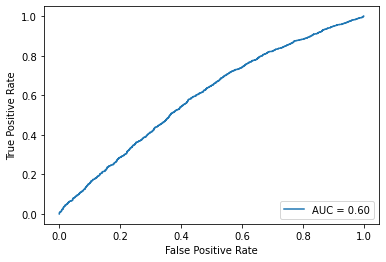


Scores for Doctor
Doctor alpha AUROC: 0.596
Doctor alpha AUPR: 0.578


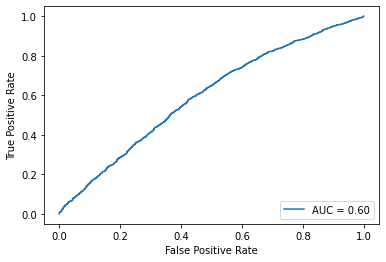

In [30]:
#scores 
print('Scores for softmax')
auc, aupr = get_scores(attack_label_real, prob)
print()
print('Scores for Doctor')
auc2, aupr2 = get_scores(attack_label_real, doc_alpha, 'Doctor alpha')

In [34]:
data = np.array([np.array(y_pred),np.array(attack_label_real), prob, np.array(doc_alpha)])

In [35]:
dataset = pd.DataFrame({'target': data[0, :],'attack_res': data[1, :], 'max_softmax_score': data[2, :], 'doctor_score': data[3, :]})
dataset.head()

,target,attack_res,max_softmax_score,doctor_score
0,1.0,1.0,0.791538,0.669988
1,1.0,1.0,0.993234,0.986559
2,0.0,1.0,0.839577,0.730625
3,1.0,1.0,0.818450,0.702821
4,0.0,1.0,0.901055,0.821690


<Axes: xlabel='max_softmax_score', ylabel='Count'>

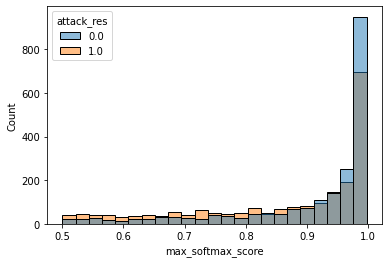

In [39]:
import seaborn as sns
sns.histplot(data=dataset, x="max_softmax_score", hue="attack_res")

<Axes: xlabel='doctor_score', ylabel='Count'>

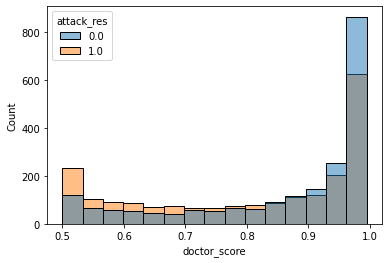

In [38]:
sns.histplot(data=dataset, x="doctor_score", hue="attack_res")